### 8.1.2 Modularization

In [2]:
getwd()

[1] "/"

In [3]:
setwd("/root/")
dir()

[1] "README.md"                   "ch01.Rmd"                   
 [3] "ch01.nb.html"                "ch02.Rmd"                   
 [5] "ch02.nb.html"                "ch03.Rmd"                   
 [7] "ch03.nb.html"                "ch04.Rmd"                   
 [9] "ch04.nb.html"                "ch05.ipynb"                 
[11] "ch06.ipynb"                  "ch07.ipynb"                 
[13] "ch08.ipynb"                  "dataset"                    
[15] "lagp-benchmark.ipynb"        "study-surrogates-2020.Rproj"

In [4]:
ball <- read.csv("dataset/ball.csv")

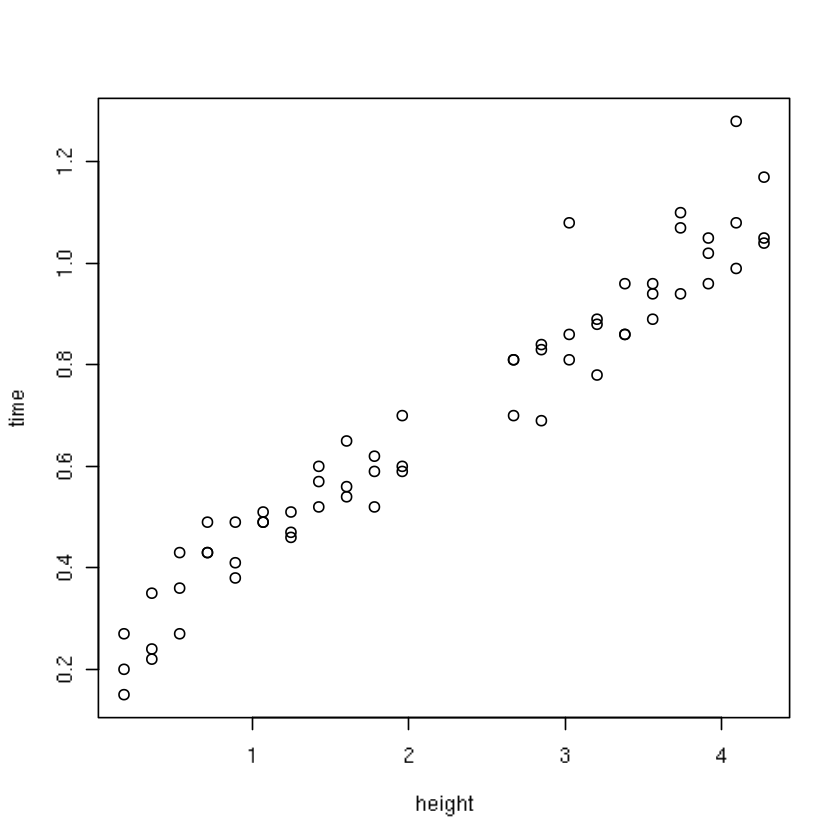

In [5]:
plot(ball, xlab="height", ylab="time")

In [8]:
library(tidyverse)

In [9]:
ball %>% group_by(height) %>% count()

height,n
<dbl>,<int>
0.178,3
0.356,3
0.534,3
0.712,3
0.890,3
1.068,3
1.246,3
1.424,3
1.602,3


In [12]:
mod1 <- (lm(time ~ height, data = ball))
summary(mod1)


Call:
lm(formula = time ~ height, data = ball)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.126672 -0.056838 -0.003417  0.037480  0.227148 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.237803   0.017314   13.73   <2e-16 ***
height      0.203255   0.006727   30.22   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07024 on 61 degrees of freedom
Multiple R-squared:  0.9374,	Adjusted R-squared:  0.9363 
F-statistic:   913 on 1 and 61 DF,  p-value: < 2.2e-16


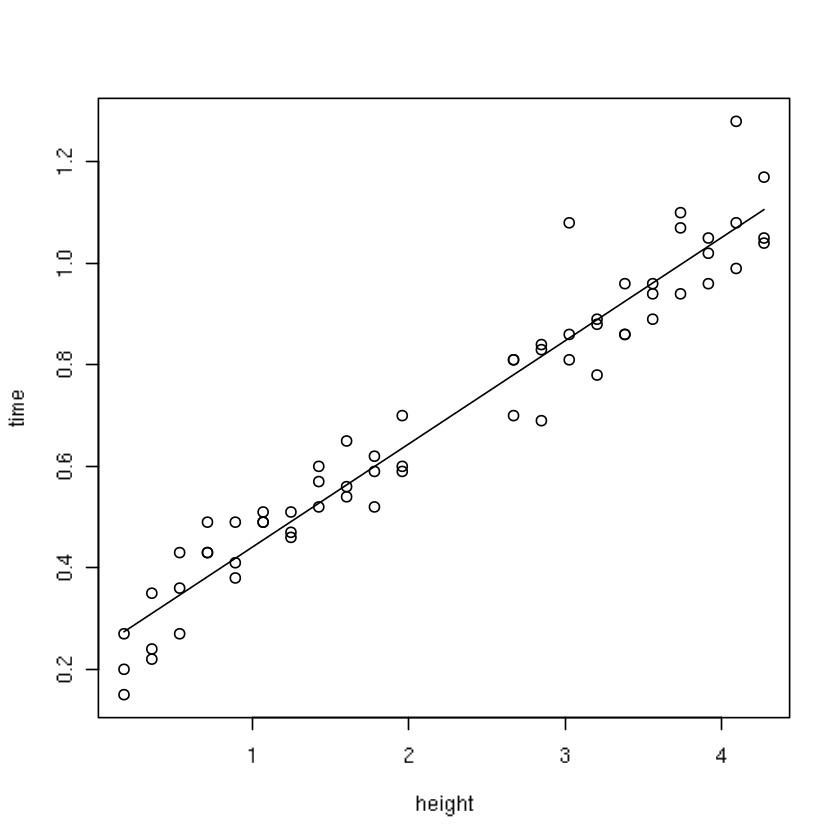

In [16]:
plot(ball)
lines(ball$height, predict(mod1))

In [138]:
mod2 <- (lm(time ~ sqrt(height), data = ball))
summary(mod2)


Call:
lm(formula = time ~ sqrt(height), data = ball)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.150620 -0.055470 -0.005667  0.037101  0.258835 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.06683    0.02876  -2.324   0.0235 *  
sqrt(height)  0.53772    0.01934  27.810   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07589 on 61 degrees of freedom
Multiple R-squared:  0.9269,	Adjusted R-squared:  0.9257 
F-statistic: 773.4 on 1 and 61 DF,  p-value: < 2.2e-16


In [140]:
2 / coef(mod2)[2]^2

sqrt(height) 
    6.917062

In [141]:
mod3 <- (lm(time ~ sqrt(height) - 1, data = ball))
summary(mod3)


Call:
lm(formula = time ~ sqrt(height) - 1, data = ball)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.145937 -0.058144 -0.006645  0.022872  0.277747 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
sqrt(height) 0.495340   0.006653   74.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07854 on 62 degrees of freedom
Multiple R-squared:  0.9889,	Adjusted R-squared:  0.9888 
F-statistic:  5544 on 1 and 62 DF,  p-value: < 2.2e-16


In [142]:
2 / coef(mod3)[1]^2

sqrt(height) 
    8.151226

In [130]:
library(laGP)
field.fit <- newGP(as.matrix(ball$height), ball$time, d=0.1,
                  g=var(ball$time)/10, dK=TRUE)
eps <- sqrt(.Machine$double.eps)
mle <- jmleGP(field.fit, drange=c(eps, 10), grange=c(eps, var(ball$time)),
             dab=c(3/2, 8))

In [54]:
mle

d,g,tot.its,dits,gits
<dbl>,<dbl>,<int>,<int>,<int>
0.8967258,0.02108801,27,15,12


In [55]:
hr <- range(ball$height)
hs <- seq(0, 1, length=100)
heights <- hs*diff(hr) + hr[1]
p <- predGP(field.fit, as.matrix(heights), lite=TRUE)
deleteGP(field.fit)

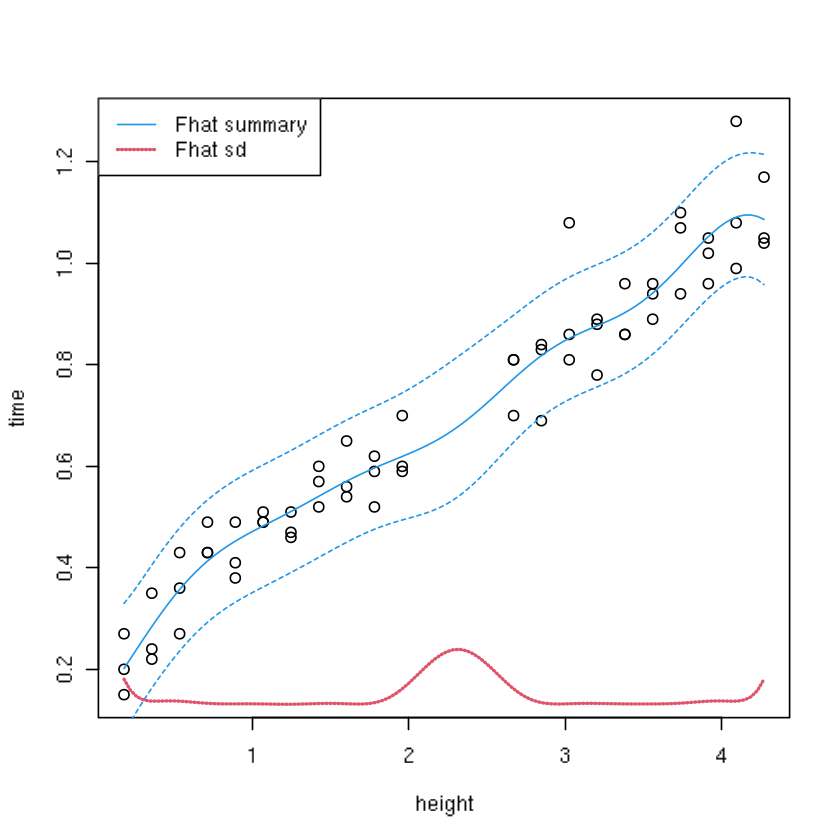

In [56]:
plot(ball, xlab="height", ylab="time")
lines(heights, p$mean, col=4)
lines(heights, qnorm(0.05, p$mean, sqrt(p$s2)), lty=2, col=4)
lines(heights, qnorm(0.95, p$mean, sqrt(p$s2)), lty=2, col=4)
lines(heights, 10*sqrt(p$s2)-0.6, col=2, lty=3, lwd=2)
legend("topleft", c("Fhat summary", "Fhat sd"), lty=c(1,3), 
  col=c(4,2), lwd=1:2)

In [60]:
timedrop <- function(x, u, hr, gr) {
  g <- diff(gr)*u + gr[1]
  h <- diff(hr)*x + hr[1]
  return(sqrt(2*h/g))
}

In [159]:
gr <- c(6, 14)

In [160]:
library(lhs)
XU <- maximinLHS(21, 2)
yM <- timedrop(XU[,1], XU[,2], hr, gr)

In [161]:
yM

[1] 0.8246865 0.5152389 0.8273118 0.4523110 0.3296618 1.0019500 0.9071908
 [8] 0.7507907 0.5990085 0.5410388 0.4801006 1.0689069 0.7725182 0.3365464
[15] 0.7317630 0.5996194 0.5889099 0.8924853 0.2201918 0.5469162 0.8205163

In [162]:
yMhat <- newGPsep(XU, yM, d=0.1, g=1e-7, dK=TRUE)
mle <- mleGPsep(yMhat, tmin=eps, tmax=10)

In [163]:
mle

$d
[1] 0.7885422 5.8538485

$its
[1] 29

$msg
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

$conv
[1] 0

In [174]:
us <- seq(0, 1, length=6)
XX <- expand.grid(hs, us)
pm <- predGPsep(yMhat, XX, lite=TRUE)
str(pm)

List of 4
 $ mean: num [1:600] 0.278 0.297 0.315 0.333 0.35 ...
 $ s2  : num [1:600] 3.73e-05 3.15e-05 2.66e-05 2.25e-05 1.90e-05 ...
 $ df  : num 21
 $ llik: num 62.5


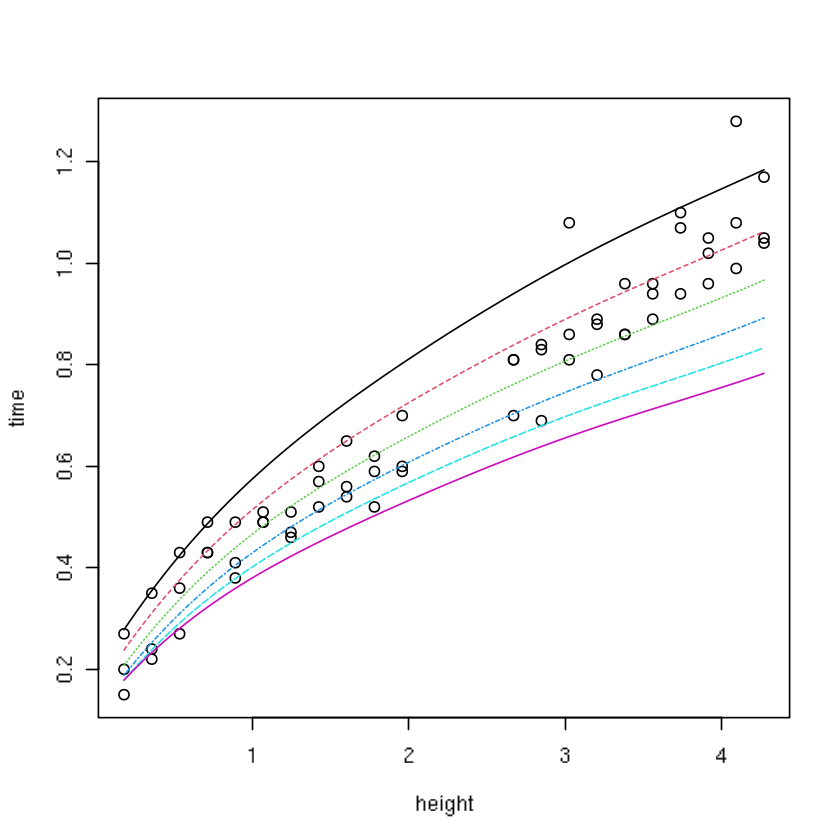

In [175]:
plot(ball)
matlines(heights, matrix(pm$m, ncol=length(us)))

In [118]:
bhat.fit <- function(X, yF, Ym, da, ga, clean=TRUE)
 {
  bhat <- newGPsep(X, yF - Ym, d=da$start, g=ga$start, dK=TRUE)
  if(ga$mle) cmle <- mleGPsep(bhat, param="both", tmin=c(da$min, ga$min),
    tmax=c(da$max, ga$max), ab=c(da$ab, ga$ab))
  else cmle <- mleGPsep(bhat, tmin=da$min, tmax=da$max, ab=da$ab)
  cmle$nll <- - llikGPsep(bhat, dab=da$ab, gab=ga$ab)
  if(clean) deleteGPsep(bhat)
  else { cmle$gp <- bhat; cmle$gptype <- "sep" }        
  return(cmle)
 }

In [119]:
calib <- function(u, XF, yF, yMhat, fit, clean=TRUE)
 {
  XFu <- cbind(XF, matrix(rep(u, nrow(XF)), ncol=length(u), byrow=TRUE))
  Ym <- predGPsep(yMhat, XFu, lite=TRUE)$mean
  cmle <- fit(XF, yF, Ym, clean=clean)
  return(cmle)
 }

In [120]:
u <- seq(0, 1, length=100)
XF <- as.matrix((ball$height - hr[1])/diff(hr))

In [121]:
formals(bhat.fit)$da <- darg(d=list(mle=TRUE), X=XF)
formals(bhat.fit)$ga <- garg(g=list(mle=TRUE), y=ball$time)

In [122]:
unll <- rep(NA, length(u))
for(i in 1:length(u)) 
  unll[i] <- calib(u[i], XF, ball$time, yMhat, bhat.fit)$nll

In [123]:
obj <- function(x, XF, yF, yMhat, fit) calib(x, XF, yF, yMhat, fit)$nll
soln <- optimize(obj, lower=0, upper=1, XF=XF, yF=ball$time, 
  yMhat=yMhat, fit=bhat.fit)
uhat <- soln$minimum

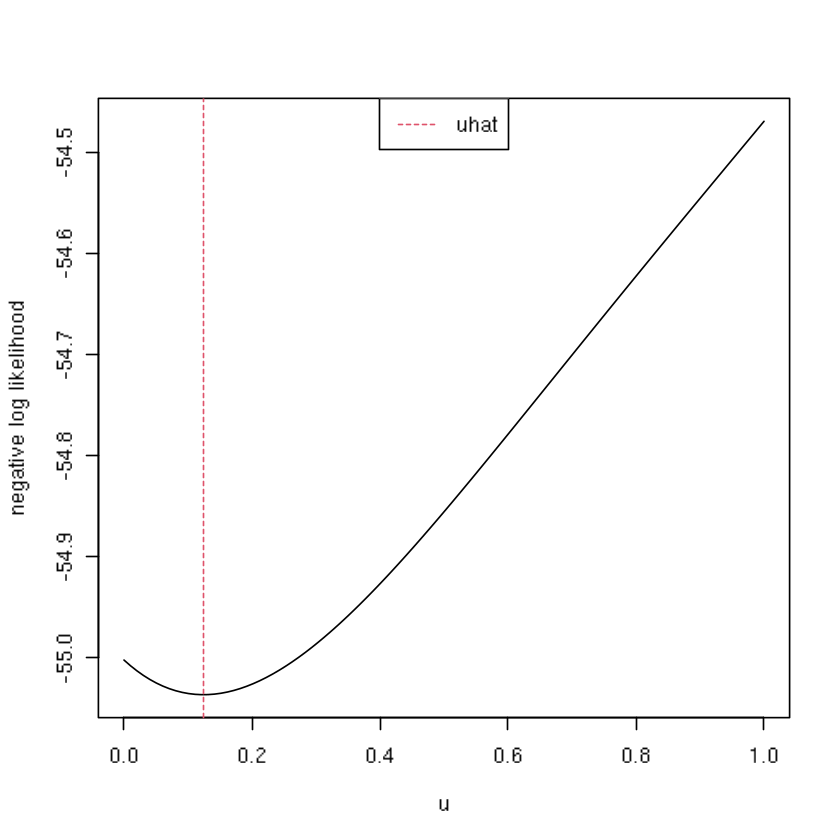

In [124]:
plot(u, unll, type="l", xlab="u", ylab="negative log likelihood")
abline(v=uhat, col=2, lty=2)
legend("top", "uhat", lty=2, col=2)

In [21]:
ghat <- uhat*diff(gr) + gr[1]
ghat

[1] 7.648903

### 8.1.3 Calibration as optimization

In [23]:
bhat <- calib(uhat, XF, ball$time, yMhat, bhat.fit, clean=FALSE)

In [24]:
pb <- predGPsep(bhat$gp, as.matrix(hs), nonug=TRUE)
sb <- sqrt(diag(pb$Sigma))
q1b <- qnorm(0.95, pb$mean, sb)
q2b <- qnorm(0.05, pb$mean, sb)

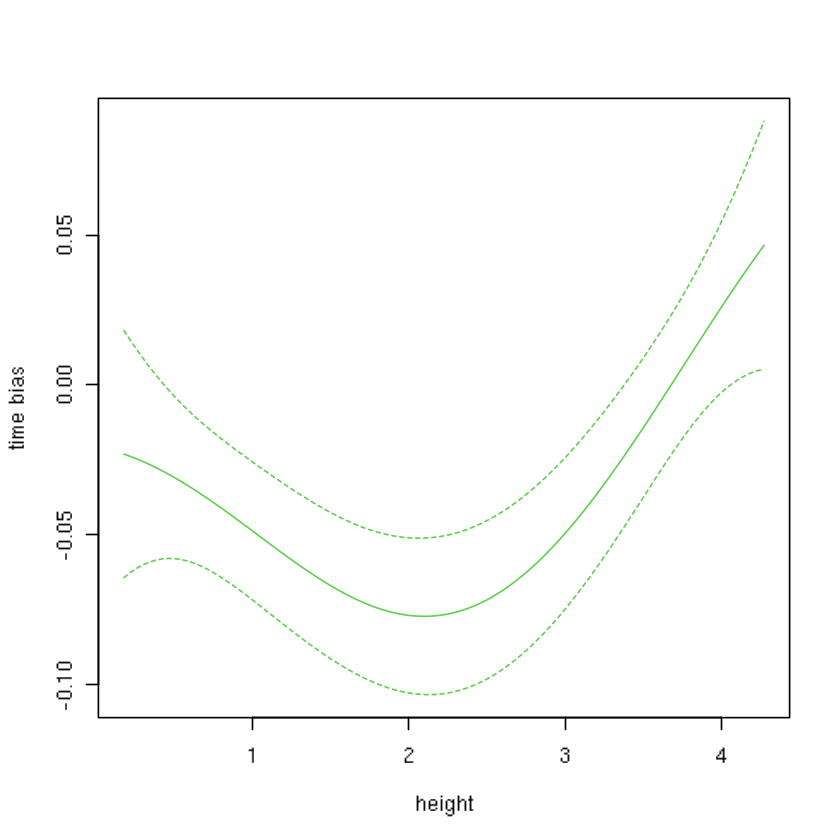

In [25]:
plot(heights, pb$mean, type="l", xlab="height", ylab="time bias", 
  ylim=range(c(q1b, q2b)), col=3)
lines(heights, q1b, col=3, lty=2)
lines(heights, q2b, col=3, lty=2) 

In [26]:
pm <- predGPsep(yMhat, cbind(hs, uhat))
q1m <- qnorm(0.95, pm$mean, sqrt(diag(pm$Sigma)))
q2m <- qnorm(0.05, pm$mean, sqrt(diag(pm$Sigma)))

In [27]:
m <- pm$mean + pb$mean
Sigma.Rhat <- pm$Sigma + pb$Sigma - diag(eps, length(m))

In [28]:
library(mvtnorm)
yR <- rmvnorm(30, m, Sigma.Rhat)

In [29]:
pbs2 <- predGPsep(bhat$gp, as.matrix(hs))
s <- sqrt(diag(pm$Sigma + pbs2$Sigma))
q1 <- qnorm(0.95, m, s)
q2 <- qnorm(0.05, m, s)
deleteGPsep(bhat$gp)

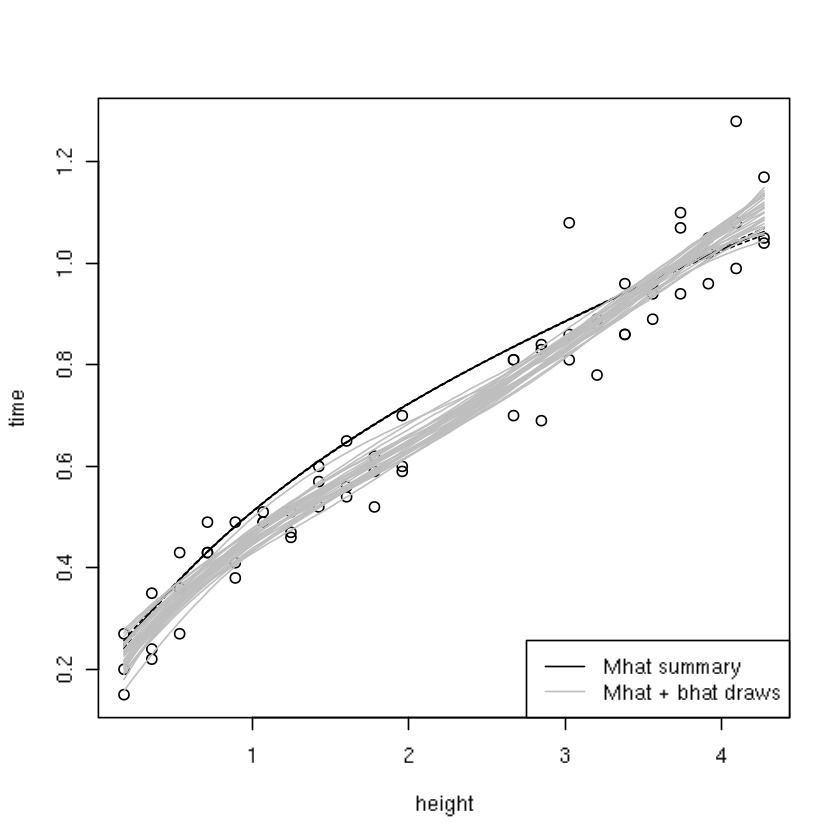

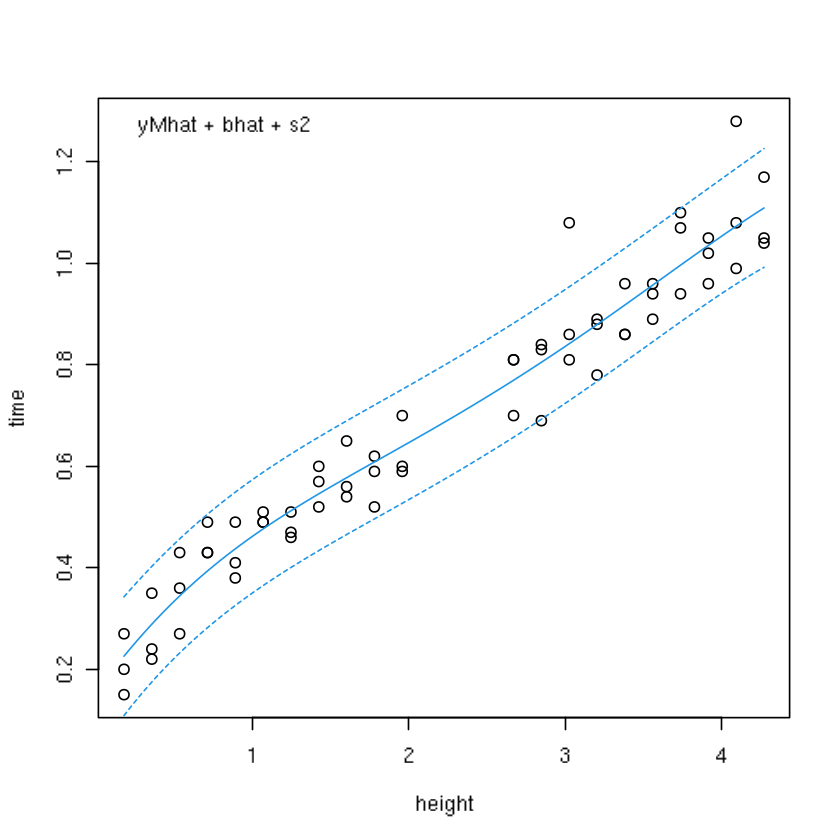

In [32]:
#par(mfrow=c(1,2), pty="s")
plot(ball)
lines(heights, pm$mean)
lines(heights, q1m, lty=2)
lines(heights, q2m, lty=2)
matlines(heights, t(yR), col="gray", lty=1)
legend("bottomright", c("Mhat summary", "Mhat + bhat draws"), 
  lty=c(1,1), col=c("black", "gray"))
plot(ball)
lines(heights, pm$mean + pb$mean, col=4)
lines(heights, q1, col=4, lty=2)
lines(heights, q2, col=4, lty=2)
legend("topleft", "yMhat + bhat + s2", bty="n")

### 8.1.4 Removing bias